# Controling a cart and pole system using REINFORCE
Author: Ruben Martinez Cantin <rmcantin@unizar.es>.
        Universidad de Zaragoza

*Licensing Information:*  You are free to use or extend these projects for
educational purposes provided that (1) you do not distribute or publish
solutions, (2) you retain this notice, and (3) you provide clear
attribution to Ruben Martinez Cantin and the University of Zaragoza.

In this lab, you will implement a policy search algorithm to control a cart and pole scenario using the OpenAI Gym.

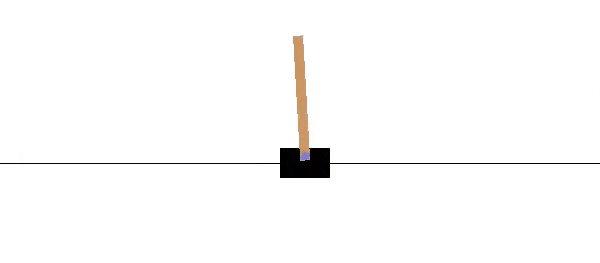

In this environment, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. The episode also ends after 200 timesteps for `CartPole-v0` and 500 timesteps for CartPole-v1.

## Environment Description
(adapted from https://github.com/openai/gym/wiki/CartPole-v0)

## States
4 continuous values

|Num|State name|Min|Max|
|---|----------|---|---|
| 0 |Cart Position |-2.4|2.4|
| 1 | Cart Velocity|-Inf|Inf|
|2|Pole Angle|~ -41.8°|~ 41.8°|
|3|Pole Velocity At Tip|-Inf|Inf|


## Actions
2 discrete actions

| Num | Action |
|-----|--------|
|0|Push cart to the left|
|1|Push cart to the right|


Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

## Reward
Reward is 1 for every step taken, including the termination step.

## Starting State
All states are assigned a uniform random value between ±0.05.


## Episode Termination

1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200 (500 for v1).

For development and debugging, it is useful to start with `CartPole-v0` because the episodes are shorter (200 timesteps). However, the system should be able to work on `CartPole-v1` (500 timesteps).

In [ ]:
#@title install dependencies
# remove ` > /dev/null 2>&1` to see what is going on under the hood
!pip install gym==0.22 pyvirtualdisplay pygame  > /dev/null 2>&1
!apt-get install -y xvfb ffmpeg > /dev/null 2>&1

In [ ]:
#@title import numpy and gym
import numpy as np
import gym

In [ ]:
#@title code to display animations
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

## modified from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=TCelFzWY9MBI

def show_video():
  mp4list = glob.glob('/content/video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, '/content/video', force=True)
  return env

In [ ]:
#@title set up virtual display
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
#@title test virtual display

#@markdown If you see a video of a cart-pole fumbling about, setup is complete!
env = wrap_env(gym.make("CartPole-v0"))

observation = env.reset()
for i in range(10):
    env.render(mode='rgb_array')
    obs, rew, term, _ = env.step(env.action_space.sample() )
    if term:
      break;

env.close()
print('Loading video...')
show_video()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


Loading video...


# Question 1: Random and Naive Agents
Before doing any RL, we are going to get familiar with the environment. First, you can use the `NaiveAgent`, which is already implemented. You can change the agent with the selector in the last cell. There, you can also change the environment used. You can try [similar environments](https://gym.openai.com/envs/#classic_control) from OpenAI Gym.

Note that `NaiveAgent` does not learn and its policy is very simple, but it is better than doing nothing.

* Run `CartPole-v0` and figure out what the policy is doing.

This is called bang-bang control, and it is the simplest controller that can be designed. This is the kind of controller that a thermostat uses.

Next, you should implement a random policy. The policy should behave randomly independently of the state of the system. This is the kind of policy that should be called for exploration if we used an epsilon-greedy policy.

* Implement the policy method for the `RandomAgent` class.

Note that you don’t need to implement the rest of the methods because `RandomAgent` does not learn. The `NaiveAgent` should be able to outperform the `RandomAgent`, even with such a simple policy.


In [ ]:
#@title abstract agent class
#@markdown this just defines the structure of an agent
class PGAgent:
    '''Abstract class for Policy Gradient Agents'''

    def policy(self, state):
        raise NotImplementedError

    def gradient_log_policy(self, state, action):
        return 0

    def update_policy(self, grads, rewards):
        pass

    def update_learning_rate(self, iteration):
        pass

In [ ]:
#@title Random agent class
#@markdown you need to implement `policy()`
class RandomAgent(PGAgent):
    '''Agent that always follows a random policy.'''

    def policy(self, state):
        '''Returns a list or numpy vector with the probability for each action.
        All the returned values must add to 1.
        '''
        # *** YOUR CODE HERE ***
        return [0.5, 0.5]

In [ ]:
#@title Naive agent class
#@markdown It already implements bang-bang control
class NaiveAgent(PGAgent):
    '''Agent that uses a simple bang-bang controller.'''

    def policy(self, state):
        if state[2] < 0:
            return [1, 0]
        else:
            return [0, 1]

We compared the performance of a NaiveAgent with a RandomAgent on the CartPole-v0 environment.

As expected, the NaiveAgent consistently outperformed the RandomAgent. The NaiveAgent's scores, averaging around 40-50, showed more stability due to its simple control strategy, which helps keep the pole balanced.

In contrast, the RandomAgent, with no control logic, had lower scores averaging around 20, highlighting the importance of even basic policies in achieving stability in control tasks.

# Question 2: Linear Agent
Now we are going to implement our first agent using policy gradient. You need to complete the methods:
* `__init__`
* `policy`
* `policy_gradient`
* `update_policy`
* `updale_learning_rate`

First, we need to initialize the parameter vector for the policy in the `__init__` method. In this case, we cannot initialize everything to 0. A good strategy is to use a random value. Because we might need positive or negative values, the weights might be samples from a normal distribution (see `numpy.random.randn`).

You can also include any other initialization parameter.

## Policy:
We are going to use a softmax policy. Remember that the equation is

$$
  \pi_\theta (a|x) = \frac{e^{\phi(x,a)^T \theta}}{\sum_b e^{\phi(x,b)^T \theta}}
$$

In this case, the policy should return 2 probability values. One for the `action = left`, and the other for `action = right`.

The features are directly the state times an indicator function for the action. Another way to see the features is that the policy is actually the combination of two different functions: one for the probability of the left action and one for the probability of the right action, each with a different set of parameters.

That is, the policy can be written as:

$$ p(a_t = left| x_t = X) \propto e^{X_0\theta_0+\ldots+X_3\theta_3} $$
$$ p(a_t = right| x_t = X) \propto e^{X_0\theta_4+\ldots+X_3\theta_7} $$


where X is the value of the state vector at that moment. As you can see, with this policy, the number of parameters is `n_states * n_actions`. Remember that the symbol means proportional, because we are computing only the numerator of the policy. Then, we sum all the probabilities to get the denominator and normalize all the values. In the final vector, you should have that `p(a=left) + p(a=right) = 1`.

## Gradient-Log:
Remember that the gradient-log of the softmax policy is:

$$ \nabla_\theta \log \pi_\theta(a|x) = \phi(x,a) - \sum_b \pi_\theta(b|x)\phi(x,b) $$

In this case, the gradient should be computing considering **the actual action that has been taken**. Note that the action taken might not be the one with the highest probability. This gradient should be a vector with a partial derivative for each one of the parameters.

**Important**: if a parameter is not involved in an action, that feature is 0. For example, these are some values of the gradient (we have removed the `xt = X` for clarity).

$$\frac{\partial \log p(a_t = left)}{\partial \theta_0} = X_0 - (X_0  \cdot  p(a_t = left) + 0 \cdot p(a_t=right))$$

$$\frac{\partial \log p(a_t = left)}{\partial \theta_4} = 0 - (0  \cdot  p(a_t = left) + X_0 \cdot p(a_t=right))$$

$$\frac{\partial \log p(a_t = right)}{\partial \theta_0} = 0 - (X_0  \cdot  p(a_t = left) + 0 \cdot p(a_t=right))$$



---
### IMPORTANT: Gradient checking
You might one to check the values of your gradient for debugging. For each parameter, you can perturb its value with a small value epsilon and compute the finite difference gradient approximation:

$$\frac{\partial \log p(a_t = left)}{\partial \theta_0} \approx \frac{\log \pi_\theta(a_t = left|\theta_0 + ϵ)- \log \pi_\theta(a_t = left|\theta_0 - ϵ)}{2ϵ}$$

You can use `numpy.isclose` and `numpy.allclose` to compare similar values.

---


## Policy update:
In the `run_episode` method of the `CartPolePS` class, you can check how the simulator follows the policy and collect a list of gradients and rewards for each time step. Now, it is your turn to fill the `update_policy` method and update the policy parameters with those lists.

You should follow the REINFORCE algorithm:

* for each step t in episode do:

$$U_t \leftarrow \sum_{i=t+1}^T R_i$$
$$\theta \leftarrow \theta + \alpha \nabla_\theta \log \pi_\theta(a_t|x_t) U_t$$

Note that, the list of gradients and rewards should be the same size as the number of timesteps of the episode (for example: 200). Then, you should update the parameters of the policy also 200 times, before running the next episode.

Important: do not worry about efficiency in this part. Grading would be based on the accuracy of the results and the technical quality of the report.

## Update learning rate:
You can achieve a decent performance with a constant learning rate. However, it might be tricky to find a good value. Instead, we are going to use a decaying sequence, that is, we make alpha with a smaller value after each episode.

The simplest decaying `alpha = 1/k`, where k is the number of episodes that have run. However, the sequence starts {1, 0.5, 0.33, 0.25…} which are quite large values.

Instead we can use `alpha = 1/(k + c)`, with a large constant value for c. Then, the initial values of the sequence are smaller, but we keep the decaying effect.


In [ ]:
#@title Linear agent class
#@markdown you should complete where you find `***YOUR CODE HERE***`
class LinearAgent(PGAgent):
    '''Agent that uses a softmax policy trained using REINFORCE.'''

    def __init__(self, n_states, n_actions):
        '''Define all the elements that you might need.

        Instance variables that you need to define:
        - Policy parameters
        - Learning rate

        Should initialize the policy parameters using samples from a
        normal distribution Check numpy.random.randn

        There should be a parameter for each feature (see policy). You
        might able to reduce the code size by vectorizing the
        operations.
        '''
        # *** YOUR CODE HERE ***
        self.theta = np.random.randn(n_states, n_actions)
        self.learning_rate = 0.01
        self.n_states = n_states
        self.n_actions = n_actions

    def policy(self, state):
        '''Returns a list or numpy vector with the probabilities for each action.

        For the features, you should directly use the state multiplied
        by the indicator function of the action. Remember: for the
        "left" action, indicator=1 if action=left and indicator=0 if
        action=right.

        Finally, you should use the softmax expresion for the
        probabilities, as seen in the class slides.

        '''
        # *** YOUR CODE HERE ***
        # preferences = np.dot(state, self.theta)
        preferences = np.dot(self.theta.T, state)

        exp_preferences = np.exp(preferences - np.max(preferences))  # Evita desbordamiento numérico
        probabilities = exp_preferences / np.sum(exp_preferences)

        return probabilities


    def gradient_log_policy(self, state, action):
        '''Returns the gradient of the log of the policy given the last state
        and action.

        You might use the datatype that you find more suitable to
        update the policy in the next method.

        Remember: The gradient of the log for the softmax policy is
        the features given the selected action minus the sum over all
        action of the features times the probability of each action.

        '''
        # *** YOUR CODE HERE ***
        probabilities = self.policy(state)

        grad_log = np.zeros_like(self.theta)

        for a in range(self.n_actions):
            feature_vector = state if a == action else np.zeros_like(state)
            grad_log[:, a] = feature_vector - probabilities[a] * state

        return grad_log

    def update_policy(self, grads, rewards):
        '''Update the parameters of the policy given an episode.

        grads and rewards contain a list of all the policy gradients
        and rewards collected at each timestep of the episode. You
        should use that to update the parameters of the policy as many
        times as possible.
        '''
        # *** YOUR CODE HERE ***
        T = len(rewards)
        cumulative_rewards = np.zeros(T)

        cumulative_rewards[-1] = rewards[-1]

        for t in reversed(range(T)):
          cumulative_rewards[t] = rewards[t] + (cumulative_rewards[t + 1] if t + 1 < T else 0)

        # Actualiza los parámetros usando REINFORCE
        for t in range(T):
            self.theta += self.learning_rate * grads[t] * cumulative_rewards[t]


    def update_learning_rate(self, iteration):
        '''Update the learning rate after each episode. (OPTIONAL)

        Initially, ignore this method and use a constant learning
        rate. Once your policy and gradient are working, you can
        optimize the learning rate.

        This method is called after each episode to update the
        learning rate. This can be used to have a diminishing learning
        rate and follow the Robbins-Monrow conditions.

        Recomended values for the learning rate are, for example:

        - alpha = 1/i
        - alpha = 1/(i + c)

        where i is the number of episode (iteration) and c is a
        constant. The constant can be used to avoid very large rates
        in the first iterations.
        '''
        # *** YOUR CODE HERE ***
        c = 40
        self.learning_rate = 1 / (iteration + c)

The class `CartPolePS` has already all the code necessary to run Policy Search with any of the agents defined before. Everything is already implemented, but it might be interesting to check the `run_episode` method to see how this works.

In [ ]:
#@title CartPole Policy Search algorithm
#@markdown this class takes an agent and enviroment and has the methods both for training and evaluation.
class CartPolePS:
    '''Class to configure the Gym environment and run the training and
    testing scenarios.

    You should not need to change anything from this code, except the
    environment in the agent which are defined in the __init__
    method. If you decide to change anything, add a commentary and
    explain the changes in the report.

    '''
    def __init__(self, agent='naive', env_name="CartPole-v1"):

        self.train_episode_rewards = []
        self.eval_episode_rewards = []
        self.counter = 0

        self.env = wrap_env(gym.make(env_name))
        self.n_states = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n


        if agent=='naive':
          self.agent = NaiveAgent()
        elif agent == 'random':
          self.agent = RandomAgent()
        elif agent == 'linear':
          self.agent = LinearAgent(self.n_states, self.n_actions)
        else:
          raise RuntimeError("Incorrect agent name!")


    def run_episode(self):
        '''Run an iteration of the REINFORCE algorithm.

        - Collect all data from a single episode
        - Compute the policy gradient at each iteration
        - Update the policy parameters at the end of the episode
        '''

        # Initial state
        state = self.env.reset()
        grads, rewards, actions = [], [], []
        score = 0

        while True:
            # Select action and find new step
            action_probabilities = self.agent.policy(state)
            action = np.random.choice(self.n_actions, p=action_probabilities)
            next_state, reward, done, info = self.env.step(action)

            # Compute gradient
            grad = self.agent.gradient_log_policy(state, action)

            # Keep a record of the grads, rewards and actions of this
            # episode
            grads.append(grad)
            rewards.append(reward)
            actions.append(action)

            # We use this to report the total reward.
            score += reward

            # Before the next iteration, we update the state
            state = next_state

            if done:
                # If the episode have finished, update the policy
                # parameters
                self.agent.update_policy(grads, rewards)
                break

        # Append for logging and print
        self.train_episode_rewards.append(score)
        return score

    def run_test_episode(self, render=False):
        '''Run an episode only for testing (check total reward).

        - Collect all data from a single episode
        - The policy does not change.
        '''

        # Initial state
        state = self.env.reset()
        score = 0

        while True:
            if render:
                self.env.render(mode='rgb_array')

            # Select action and find new step
            action_probabilities = self.agent.policy(state)
            action = np.argmax(action_probabilities)
            next_state, reward, done, info_ = self.env.step(action)

            score += reward

            # Dont forget to update your old state to the new state
            state = next_state

            if done:
                break

        # Append for logging and print
        if render:
          show_video()

        return score

    def train(self, num_episodes=1000, num_evals=5, eval_freq=10):
        ''' Run multiple training episodes. '''

        for i in range(num_episodes):
            self.agent.update_learning_rate(self.counter)
            score = self.run_episode()
            self.counter += 1

            if self.counter % 100 == 0:
              print("EP: " + str(self.counter) + " Score: " + str(score))

            if self.counter % eval_freq == 0:
              eval_scores = np.zeros((num_evals, ))
              for j in range(num_evals):
                eval_scores[j] = self.run_test_episode()

              self.eval_episode_rewards.append(np.mean(eval_scores))

    def test(self, num_evals=100):
        ''' Run multiple testing episodes. '''

        eval_scores = np.zeros((num_evals, ))
        for j in range(num_evals):
          eval_scores[j] = self.run_test_episode()

        print("Average Test: ", np.mean(eval_scores))

    def close(self):
        self.env.close()

Now it is time to run the experiments with different agents, environments and duration. The history of all rewards obtained during training is stored in `cart.train_episode_rewards`. However, that trace is not representative because we are directly sampling from the stochastic policy to improve the exploration. For evaluation, we always choose the action with highest probability, resulting in a better performance.

For plotting, every `eval_freq` iterations, we are running 5 evaluation episodes and returning the average. That trace is stored in `cart.eval_episode_rewards`.

You can see that something as simple as the linear policy is good enough for the CartPole problems, but it may have trouble with more complicated environments.

In [ ]:
#@title CartPole-v0
#@markdown choose your agent, enviroment, number of training episodes and evaluation frequency

agent = 'linear' #@param ['naive', 'random', 'linear']
env_name = 'CartPole-v0' #@param ['CartPole-v0', 'CartPole-v1', 'Acrobot-v1']
num_episodes = 3000 #@param {type: "integer"}
eval_freq = 150 #@param {type: "integer"}


cart = CartPolePS(agent=agent, env_name=env_name)

cart.train(num_episodes=num_episodes, eval_freq=eval_freq)
cart.run_test_episode(render=True)

cart.close()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


EP: 100 Score: 200.0
EP: 200 Score: 140.0
EP: 300 Score: 171.0
EP: 400 Score: 154.0
EP: 500 Score: 200.0
EP: 600 Score: 200.0
EP: 700 Score: 200.0
EP: 800 Score: 200.0
EP: 900 Score: 200.0
EP: 1000 Score: 200.0
EP: 1100 Score: 200.0
EP: 1200 Score: 200.0
EP: 1300 Score: 200.0
EP: 1400 Score: 200.0
EP: 1500 Score: 200.0
EP: 1600 Score: 200.0
EP: 1700 Score: 200.0
EP: 1800 Score: 200.0
EP: 1900 Score: 200.0
EP: 2000 Score: 200.0
EP: 2100 Score: 200.0
EP: 2200 Score: 200.0
EP: 2300 Score: 200.0
EP: 2400 Score: 200.0
EP: 2500 Score: 200.0
EP: 2600 Score: 200.0
EP: 2700 Score: 200.0
EP: 2800 Score: 200.0
EP: 2900 Score: 200.0
EP: 3000 Score: 200.0


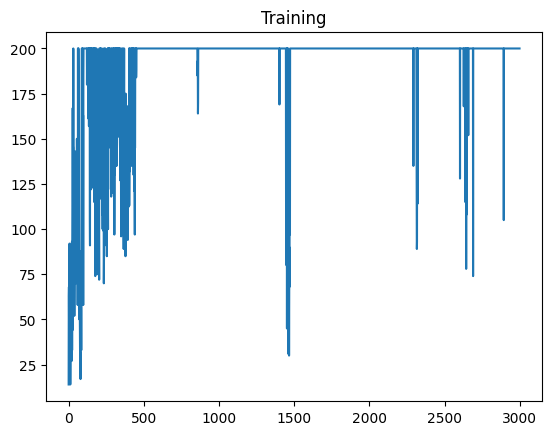

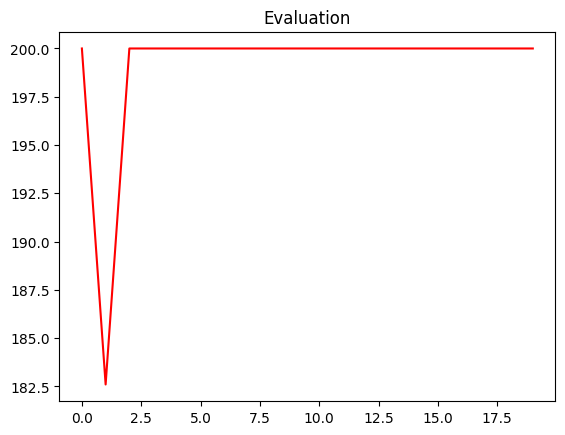

In [ ]:
#@title Plotting CartPole-v0
#@markdown Let's plot both the training and evaluation results
import matplotlib.pyplot as plt
plt.plot(cart.train_episode_rewards)
plt.title('Training')
plt.figure()
plt.plot(cart.eval_episode_rewards, 'r')
plt.title('Evaluation')
plt.show()

Training: The agent initially shows high variability in rewards, with frequent dips, indicating exploration. By around 1500 episodes, it consistently achieves high rewards, though occasional drops still occur.

During the first few episodes, there is high variability in the rewards. This suggests that the agent is exploring various policies and has not yet converged to an optimal strategy.

Episodes with Low Rewards: Throughout the training, there are several episodes with low rewards, indicating that the agent occasionally fails to balance the pole for extended periods. This may be due to the stochastic nature of the environment or insufficient policy updates.


Evaluation: After initial instability, the agent consistently achieves the maximum reward of 200, showing that it has learned a stable policy for balancing the pole.

In [ ]:
#@title CartPole-v1
#@markdown choose your agent, enviroment, number of training episodes and evaluation frequency

agent = 'linear' #@param ['naive', 'random', 'linear']
env_name = 'CartPole-v1' #@param ['CartPole-v0', 'CartPole-v1', 'Acrobot-v1']
num_episodes = 4500 #@param {type: "integer"}
eval_freq = 100 #@param {type: "integer"}


cart = CartPolePS(agent=agent, env_name=env_name)

cart.train(num_episodes=num_episodes, eval_freq=eval_freq)
cart.run_test_episode(render=True)

cart.close()

EP: 100 Score: 152.0
EP: 200 Score: 279.0
EP: 300 Score: 265.0
EP: 400 Score: 155.0
EP: 500 Score: 500.0
EP: 600 Score: 500.0
EP: 700 Score: 500.0
EP: 800 Score: 47.0
EP: 900 Score: 500.0
EP: 1000 Score: 500.0
EP: 1100 Score: 154.0
EP: 1200 Score: 500.0
EP: 1300 Score: 500.0
EP: 1400 Score: 500.0
EP: 1500 Score: 500.0
EP: 1600 Score: 500.0
EP: 1700 Score: 500.0
EP: 1800 Score: 500.0
EP: 1900 Score: 500.0
EP: 2000 Score: 500.0
EP: 2100 Score: 500.0
EP: 2200 Score: 500.0
EP: 2300 Score: 500.0
EP: 2400 Score: 500.0
EP: 2500 Score: 500.0
EP: 2600 Score: 500.0
EP: 2700 Score: 500.0
EP: 2800 Score: 267.0
EP: 2900 Score: 500.0
EP: 3000 Score: 500.0
EP: 3100 Score: 500.0
EP: 3200 Score: 500.0
EP: 3300 Score: 500.0
EP: 3400 Score: 500.0
EP: 3500 Score: 500.0
EP: 3600 Score: 500.0
EP: 3700 Score: 500.0
EP: 3800 Score: 500.0
EP: 3900 Score: 500.0
EP: 4000 Score: 500.0
EP: 4100 Score: 500.0
EP: 4200 Score: 500.0
EP: 4300 Score: 500.0
EP: 4400 Score: 500.0
EP: 4500 Score: 500.0


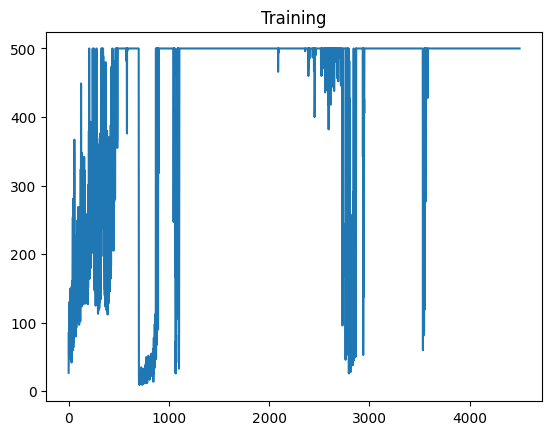

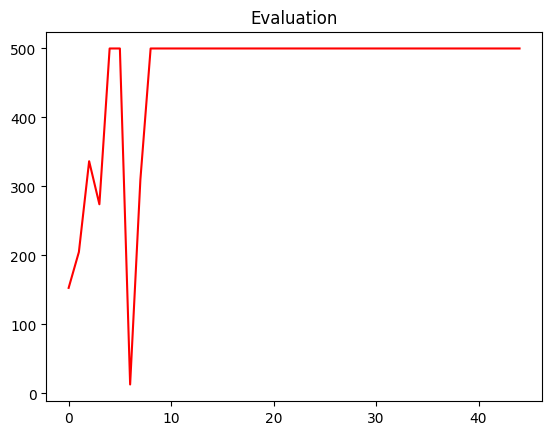

In [ ]:
#@title Plotting CartPole-v1
#@markdown Let's plot both the training and evaluation results
import matplotlib.pyplot as plt
plt.plot(cart.train_episode_rewards)
plt.title('Training')
plt.figure()
plt.plot(cart.eval_episode_rewards, 'r')
plt.title('Evaluation')
plt.show()

Training: The rewards initially fluctuate as the agent learns, with some episodes reaching the maximum reward of 500. By around 1000 episodes, the agent consistently performs well, although there are occasional drops even later in training.

Evaluation: After an initial phase with variable rewards, the agent quickly stabilizes, achieving the maximum reward of 500 in all subsequent evaluations, indicating a reliable and effective policy.

In [ ]:
#@title Acrobot-v1
#@markdown choose your agent, enviroment, number of training episodes and evaluation frequency

agent = 'linear' #@param ['naive', 'random', 'linear']
env_name = 'Acrobot-v1' #@param ['CartPole-v0', 'CartPole-v1', 'Acrobot-v1']
num_episodes = 3000 #@param {type: "integer"}
eval_freq = 100 #@param {type: "integer"}


cart = CartPolePS(agent=agent, env_name=env_name)

cart.train(num_episodes=num_episodes, eval_freq=eval_freq)
cart.run_test_episode(render=True)

cart.close()

EP: 100 Score: -124.0
EP: 200 Score: -117.0
EP: 300 Score: -178.0
EP: 400 Score: -148.0
EP: 500 Score: -177.0
EP: 600 Score: -241.0
EP: 700 Score: -170.0
EP: 800 Score: -131.0
EP: 900 Score: -164.0
EP: 1000 Score: -158.0
EP: 1100 Score: -149.0
EP: 1200 Score: -140.0
EP: 1300 Score: -152.0
EP: 1400 Score: -154.0
EP: 1500 Score: -155.0
EP: 1600 Score: -148.0
EP: 1700 Score: -143.0
EP: 1800 Score: -219.0
EP: 1900 Score: -155.0
EP: 2000 Score: -219.0
EP: 2100 Score: -151.0
EP: 2200 Score: -163.0
EP: 2300 Score: -138.0
EP: 2400 Score: -140.0
EP: 2500 Score: -156.0
EP: 2600 Score: -152.0
EP: 2700 Score: -147.0
EP: 2800 Score: -146.0
EP: 2900 Score: -192.0
EP: 3000 Score: -149.0


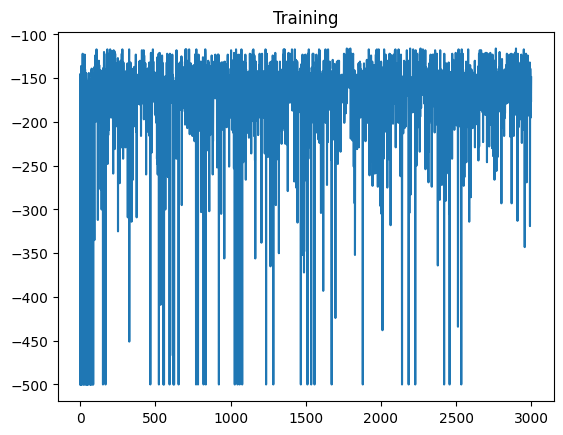

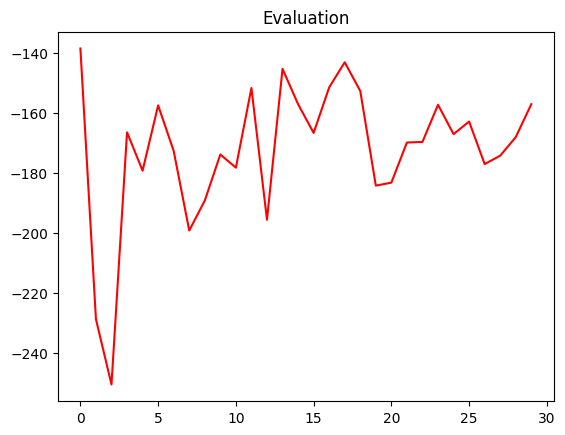

In [ ]:
#@title Plotting Acrobot-v1
#@markdown Let's plot both the training and evaluation results
import matplotlib.pyplot as plt
plt.plot(cart.train_episode_rewards)
plt.title('Training')
plt.figure()
plt.plot(cart.eval_episode_rewards, 'r')
plt.title('Evaluation')
plt.show()

Throughout the training process, the rewards fluctuate significantly. This suggests that the agent is struggling to find a consistent strategy to solve the task. The rewards frequently drop close to the minimum value of -500, which indicates that the agent often fails to reach the goal within the 500-step limit.

The training plot shows that the agent’s performance remains mostly around -150 to -300 but often drops to -500, suggesting that the agent may only succeed sporadically.

This demonstrates that while basic policy gradient methods can handle simple control tasks, they may not generalize well to more challenging reinforcement learning environments without further improvements to the model complexity or learning approach.


Given the environment noise, you might find that sometimes training is much faster than others, without changing any parameter. That is something that we need to be careful. Ideally, you should run the training multiple times and plot the average traces with the correspoding error bars, although that is not required for this lab problem.